In [1]:
import json
from collections import namedtuple, Counter

import numpy as np
import scanpy as sc
import pandas as pd
import zarr

## Image manipulation and geometry
from tifffile import TiffFile
from tifffile import imread
from skimage.io import imread as skimread

# Polygon manipulation and geometry
from shapely.geometry import Polygon
from shapely.geometry import LinearRing
from shapely import wkt
## Plotting imports
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize, to_hex, Colormap
from matplotlib.cm import ScalarMappable

### Functions for registration of Xenium to Visium data and associated analyis and visualization
## Visualization functions
from companion_functions import (
    plot_polygons
)


In [2]:
#Load the polgons from csv file
xenium_cell_polygons = pd.read_csv('nuclei_df_bugy.csv')

In [3]:
xenium_cell_polygons

,Unnamed: 0,geometry,id,cell_x,cell_y,centroid
0,0,"POLYGON ((8153.67138671875 3387.9892578125, 81...",ID_1,8140.082,3389.3010,"(8140.082, 3528.301)"
1,1,"POLYGON ((8016.0625 3461.97119140625, 8011.365...",ID_2,8001.864,3468.8760,"(8001.864, 3607.876)"
2,2,"POLYGON ((8074.77099609375 3424.279052734375, ...",ID_3,8062.877,3423.9019,"(8062.877, 3562.9019)"
3,3,"POLYGON ((7977.92236328125 3447.507568359375, ...",ID_4,7965.358,3452.9410,"(7965.358, 3591.941)"
4,4,"POLYGON ((8033.126953125 3251.503173828125, 80...",ID_5,8022.654,3250.0593,"(8022.654, 3389.0593)"
...,...,...,...,...,...,...
165130,277653,"POLYGON ((18131.0234375 21528.193359375, 18126...",ID_277654,18111.076,21530.2970,"(18111.076, 21669.297)"
165131,277654,"POLYGON ((17868.455078125 21184.75, 17867.6718...",ID_277655,17860.938,21188.3120,"(17860.938, 21327.312)"
165132,277655,"POLYGON ((18025.462890625 21214.62890625, 1802...",ID_277656,18015.506,21215.5720,"(18015.506, 21354.572)"
165133,277656,"POLYGON ((18387.8671875 21205.7265625, 18386.2...",ID_277657,18380.260,21218.1400,"(18380.26, 21357.14)"


In [4]:
xenium_cell_polygons["parsed_geometry"] = xenium_cell_polygons["geometry"].apply(wkt.loads)
# Convert parsed_geometry to list of arrays with alternating x and y values
xenium_cell_polygons["parsed_coordinates"] = xenium_cell_polygons["parsed_geometry"].apply(
    lambda geom: np.array(geom.exterior.coords).flatten()
)

In [5]:
xenium_cell_polygons["parsed_coordinates"][0]

array([8153.67138672, 3387.98925781, 8152.88818359, 3387.21875   ,
       8152.07763672, 3382.56787109, 8147.38671875, 3377.94580078,
       8138.82666016, 3374.90478516, 8136.49755859, 3374.92211914,
       8131.08251953, 3377.29052734, 8128.00097656, 3380.41821289,
       8127.23681641, 3381.97631836, 8127.25976562, 3385.08056641,
       8126.48974609, 3385.86254883, 8127.27099609, 3386.63305664,
       8127.29980469, 3390.51367188, 8128.88037109, 3394.3828125 ,
       8131.24414062, 3399.0222168 , 8134.37207031, 3402.10375977,
       8137.48681641, 3403.6328125 , 8139.81591797, 3403.61547852,
       8142.13916016, 3402.82202148, 8146.77832031, 3400.45898438,
       8152.1640625 , 3394.2097168 , 8152.92822266, 3392.65161133,
       8152.90527344, 3389.54711914, 8153.67724609, 3388.76513672,
       8153.67138672, 3387.98925781])

In [6]:
invalid_indices = []
for idx, coords in xenium_cell_polygons["parsed_coordinates"].items():
    try:
        # Reshape to (N, 2) for Polygon
        polygon = Polygon(coords.reshape(-1, 2))
        if not polygon.is_valid:
            invalid_indices.append(idx)
    except Exception as e:
        invalid_indices.append(idx)

print("Indices of invalid polygons:", invalid_indices)
print("Number of invalid polygons:", len(invalid_indices))

Indices of invalid polygons: [16328, 33038, 35339, 38782, 40952, 43377, 46752, 49724, 53898, 54165, 56264, 56929, 68342, 75225, 75487, 75633, 75849, 75888, 77393, 79306, 80136, 80801, 81755, 82192, 83487, 84027, 85628, 85834, 85877, 92139, 94075, 95738, 99686, 100755, 101409, 107005, 107608, 110288, 110776, 112450, 116711, 117983, 118117, 119614, 120146, 128175, 130051, 130791, 132885, 134916, 134977, 138935, 140508, 142456, 142897, 142913, 143555, 146833, 148698, 151513, 151718, 152226, 152496, 154712, 154859, 155634, 159820, 162796, 163279, 163552, 164456]
Number of invalid polygons: 71


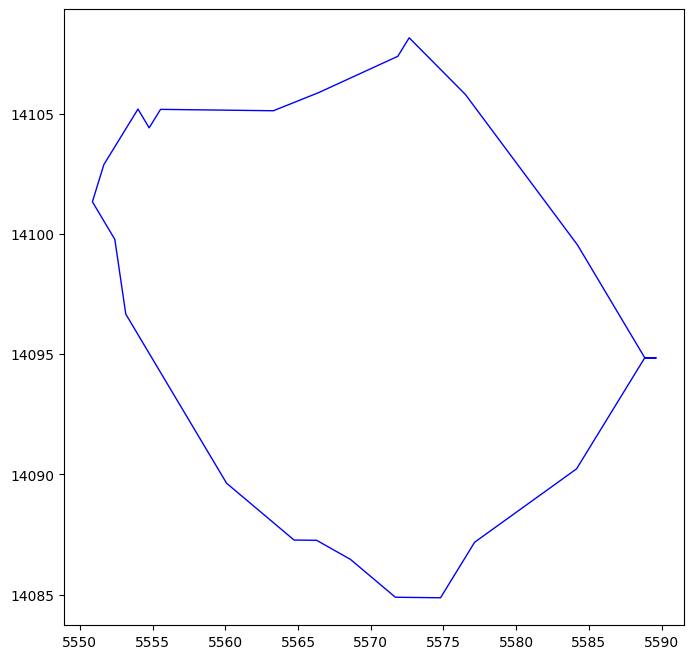

In [8]:

filtered_cell_polygons = xenium_cell_polygons.loc[invalid_indices[0]]["parsed_coordinates"]

cell_polygons = [filtered_cell_polygons.reshape(-1, 2)]

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
plot_polygons(
    cell_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="blue",
    linewidth=1,
)

In [9]:
def fix_polygon(coords):
    try:
        poly = Polygon(coords.reshape(-1, 2))
        if not poly.is_valid:
            # Attempt to fix with buffer(0)
            fixed = poly.buffer(0)
            if fixed.is_valid and not fixed.is_empty:
                return np.array(fixed.exterior.coords).flatten()
            else:
                return np.nan  # Could not fix
        else:
            return coords
    except Exception:
        return np.nan


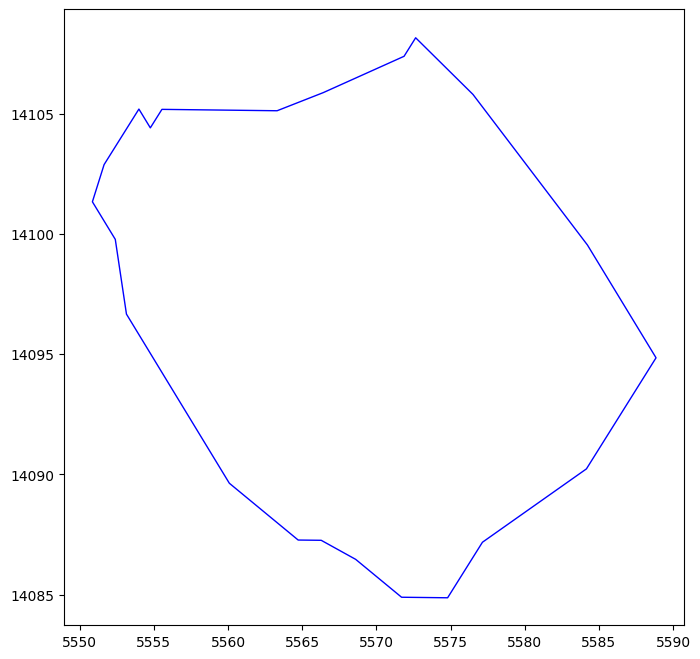

In [10]:

fixed_polygon = fix_polygon(xenium_cell_polygons.loc[invalid_indices[0]]["parsed_coordinates"])

cell_polygons = [fixed_polygon.reshape(-1, 2)]

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
plot_polygons(
    cell_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="blue",
    linewidth=1,
)

# Pipline to fix it

In [11]:
for idx in invalid_indices:
    coords = xenium_cell_polygons.at[idx, "parsed_coordinates"]
    fixed_coords = fix_polygon(coords)
    if isinstance(fixed_coords, np.ndarray):
        xenium_cell_polygons.at[idx, "parsed_coordinates"] = fixed_coords
        xenium_cell_polygons.at[idx, "parsed_geometry"] = Polygon(fixed_coords.reshape(-1, 2))
    else:
        print(f"Polygon at index {idx} could not be fixed.")

Polygon at index 54165 could not be fixed.
Polygon at index 80801 could not be fixed.
Polygon at index 85628 could not be fixed.
Polygon at index 100755 could not be fixed.
Polygon at index 146833 could not be fixed.
Polygon at index 152496 could not be fixed.
Polygon at index 162796 could not be fixed.
Polygon at index 164456 could not be fixed.


In [12]:
invalid_indices_post = []
for idx, coords in xenium_cell_polygons["parsed_coordinates"].items():
    try:
        # Reshape to (N, 2) for Polygon
        polygon = Polygon(coords.reshape(-1, 2))
        if not polygon.is_valid:
            invalid_indices_post.append(idx)
    except Exception as e:
        invalid_indices_post.append(idx)

print("Indices of invalid polygons:", invalid_indices_post)
print("Number of invalid polygons:", len(invalid_indices_post))

Indices of invalid polygons: [54165, 80801, 85628, 100755, 146833, 152496, 162796, 164456]
Number of invalid polygons: 8


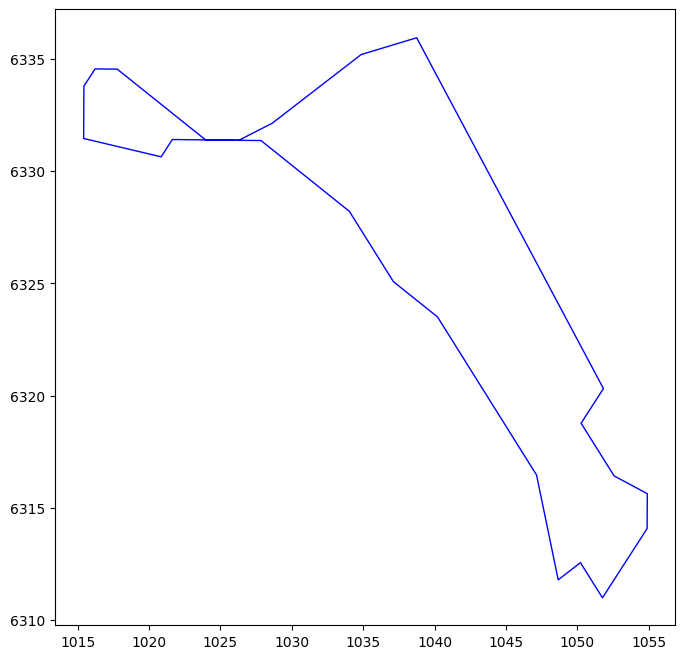

In [13]:

skandi_polygon = xenium_cell_polygons.loc[invalid_indices_post[0]]["parsed_coordinates"]

cell_polygon = [skandi_polygon.reshape(-1, 2)]

fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
plot_polygons(
    cell_polygon,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="blue",
    linewidth=1,
)

In [14]:
xenium_cell_polygons = xenium_cell_polygons.drop(index=invalid_indices_post).reset_index(drop=True)

In [15]:
invalid_indices_post = []
for idx, coords in xenium_cell_polygons["parsed_coordinates"].items():
    try:
        # Reshape to (N, 2) for Polygon
        polygon = Polygon(coords.reshape(-1, 2))
        if not polygon.is_valid:
            invalid_indices_post.append(idx)
    except Exception as e:
        invalid_indices_post.append(idx)

print("Indices of invalid polygons:", invalid_indices_post)
print("Number of invalid polygons:", len(invalid_indices_post))

Indices of invalid polygons: []
Number of invalid polygons: 0


In [16]:
xenium_cell_polygons = xenium_cell_polygons.drop(columns=["geometry", "parsed_coordinates"]).rename(columns={"parsed_geometry": "geometry"})

In [17]:
xenium_cell_polygons

,Unnamed: 0,id,cell_x,cell_y,centroid,geometry
0,0,ID_1,8140.082,3389.3010,"(8140.082, 3528.301)","POLYGON ((8153.67138671875 3387.9892578125, 81..."
1,1,ID_2,8001.864,3468.8760,"(8001.864, 3607.876)","POLYGON ((8016.0625 3461.97119140625, 8011.365..."
2,2,ID_3,8062.877,3423.9019,"(8062.877, 3562.9019)","POLYGON ((8074.77099609375 3424.279052734375, ..."
3,3,ID_4,7965.358,3452.9410,"(7965.358, 3591.941)","POLYGON ((7977.92236328125 3447.507568359375, ..."
4,4,ID_5,8022.654,3250.0593,"(8022.654, 3389.0593)","POLYGON ((8033.126953125 3251.503173828125, 80..."
...,...,...,...,...,...,...
165122,277653,ID_277654,18111.076,21530.2970,"(18111.076, 21669.297)","POLYGON ((18131.0234375 21528.193359375, 18126..."
165123,277654,ID_277655,17860.938,21188.3120,"(17860.938, 21327.312)","POLYGON ((17868.455078125 21184.75, 17867.6718..."
165124,277655,ID_277656,18015.506,21215.5720,"(18015.506, 21354.572)","POLYGON ((18025.462890625 21214.62890625, 1802..."
165125,277656,ID_277657,18380.260,21218.1400,"(18380.26, 21357.14)","POLYGON ((18387.8671875 21205.7265625, 18386.2..."


In [18]:
xenium_cell_polygons.to_csv('nuclei_df.csv', index=False)